In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from keras import models, layers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.
C:\Users\edo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\edo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\edo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\edo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Fu

In [45]:
# https://archive.ics.uci.edu/ml/datasets/Air+Quality
df = pd.read_csv('~/Downloads/AirQualityUCI.csv', sep=';')

In [46]:
df = df.drop(df.columns[:2].tolist() + df.columns[-2:].tolist(), axis=1)
for c in df.columns:
    df[c] = df[c].apply(lambda x: float(x.replace(',', '.')) if not isinstance(x, float) else x)
    df[c] = np.log(1 + df[c]).fillna(0)
df = df[df['PT08.S3(NOx)'] > 0].dropna()

C:\Users\edo\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
xs = df.drop('PT08.S3(NOx)', axis=1).values
ys = df['PT08.S3(NOx)'].values

cut = int(0.8 * len(df))
x_train, x_test = xs[:cut], xs[cut:]
y_train, y_test = ys[:cut], ys[cut:]

In [48]:
xs = df.drop('PT08.S3(NOx)', axis=1).values
ys = df['PT08.S3(NOx)'].values

cut = int(0.8 * len(df))
x_train, x_test = xs[:cut], xs[cut:]
y_train, y_test = ys[:cut], ys[cut:]

x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train[..., np.newaxis])
y_test = y_scaler.fit_transform(y_test[..., np.newaxis])

In [50]:
model = models.Sequential([
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(2),
])


def loss(y_true, y_pred):
    mean = backend.flatten(y_pred[:, 0])
    logvar = backend.flatten(y_pred[:, 1])
    labels = backend.flatten(y_true)
    return backend.mean(
        (labels - mean)**2 / (2 * backend.exp(logvar)) + logvar / 2
    )


model.compile('adam', loss)

In [51]:
hist = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=150,
    verbose=0,
)

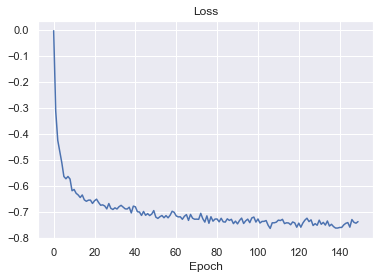

In [52]:
plt.plot(hist.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [185]:
hist.history['loss'][-1]

-0.7364596483174367

In [53]:
backend.set_learning_phase(1) # activate dropout

In [54]:
ps = np.array([
    model.predict(x_test, batch_size=2048)
    for _ in range(50)
])

In [55]:
# step 1: de-standardization
pred_mean = np.sqrt(y_scaler.var_) * ps[:, :, 0] + y_scaler.mean_
pred_var = y_scaler.var_ * np.exp(ps[:, :, 1])

# step 1.5: combining epistemic and aleatoric uncertainty
pred_mean = np.mean(pred_mean, axis=0)
pred_var = np.mean(pred_mean**2, axis=0) - np.mean(pred_mean, axis=0)**2 + np.mean(pred_var, axis=0)

# step 2: exponentiation
exp_preds = np.exp(pred_mean + pred_var / 2)
exp_vars = (np.exp(pred_var) - 1) * np.exp(2 * pred_mean + pred_var)

# step 3: confidence intervals
exp_cilo = np.exp(pred_mean - 1.96 * np.sqrt(pred_var))
exp_cihi = np.exp(pred_mean + 1.96 * np.sqrt(pred_var))

In [184]:
np.mean((pred_mean - y_scaler.inverse_transform(y_test))**2)

0.1892921702583839

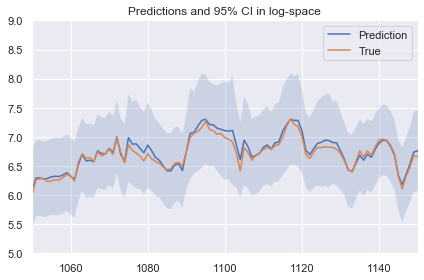

In [103]:
plt.plot(pred_mean, label='Prediction')
plt.plot(y_scaler.inverse_transform(y_test), label='True')
plt.fill_between(
    range(len(pred_mean)),
    pred_mean - 1.96 * np.sqrt(pred_var),
    pred_mean + 1.96 * np.sqrt(pred_var),
    alpha=0.2
)

plt.xlim(1050, 1150)
plt.ylim(5, 9)
plt.title('Predictions and 95% CI in log-space')
plt.legend()
plt.tight_layout()
plt.savefig('../images/uncertainty/logcipreds.png')
plt.show()

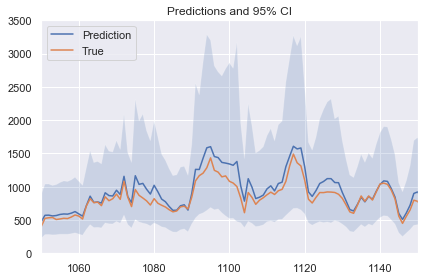

In [180]:
plt.plot(exp_preds, label='Prediction')
plt.plot(np.exp(y_scaler.inverse_transform(y_test)), label='True')
plt.fill_between(range(len(exp_preds)), exp_cilo, exp_cihi, alpha=0.2)
plt.xlim(1050, 1150)
plt.ylim(0, 3500)
plt.title('Predictions and 95% CI')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../images/uncertainty/cipreds.png')
plt.show()

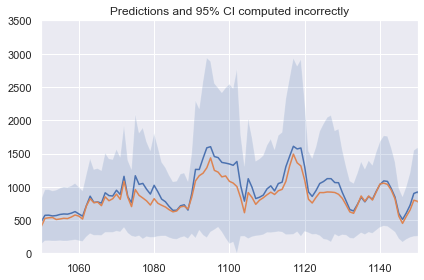

In [182]:
wrong_cilo = exp_preds - 1.96 * np.sqrt(exp_vars)
wrong_cihi = exp_preds + 1.96 * np.sqrt(exp_vars)

plt.plot(exp_preds, label='Prediction')
plt.plot(np.exp(y_scaler.inverse_transform(y_test)), label='True')
plt.fill_between(range(len(exp_preds)), wrong_cilo, wrong_cihi, alpha=0.2)
plt.xlim(1050, 1150)
plt.ylim(0, 3500)
plt.title('Predictions and 95% CI computed incorrectly')
plt.tight_layout()
#plt.savefig('../images/uncertainty/wrong_cipreds.png')
#plt.show()

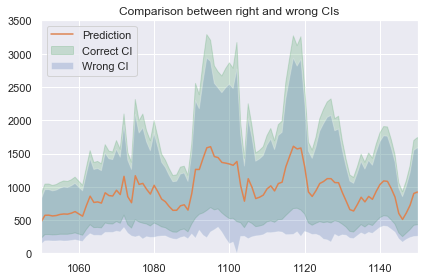

In [183]:
plt.title('Comparison between right and wrong CIs')
plt.fill_between(range(len(exp_preds)), exp_cilo, exp_cihi, alpha=0.25, label='Correct CI', color='C2')
plt.fill_between(range(len(exp_preds)), wrong_cilo, wrong_cihi, alpha=0.25, label='Wrong CI')
plt.plot(exp_preds, color='C1', label='Prediction')
plt.xlim(1050, 1150)
plt.ylim(0, 3500)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../images/uncertainty/ciwidth.png')
plt.show()